In [2]:
from zlib import crc32
theory = crc32('Сайранов'.lower().encode('utf-8'))%5+1
practice = crc32('Sayranov'.lower().encode('utf-8'))%3+1
print(theory, practice)

2 2


<hr>

In [10]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np

from copy import deepcopy

from tqdm import tqdm

#only cpu available
device = 'cpu'

Создадим модель логистической регрессии:

In [9]:
class LogisticRegression(nn.Module):
    
    def __init__(self, features, classes, samples):
        super(LogisticRegression, self).__init__()
        
        self.features = features
        self.classes = classes
        self.samples = samples
        
        self.mean = nn.Parameter(torch.randn(features * classes))
        self.sigma = nn.Parameter(torch.abs(torch.randn(features * classes)))
        
        self.distribution = torch.distributions.MultivariateNormal(torch.zeros(features*classes),
                                                                   precision_matrix=torch.eye(features*classes))
        
    def forward(self, x):
        x = x.view(-1, self.features)
        w = torch.zeros(self.features, self.classes)
        for sample in range(self.samples):
            dist_sample = self.distribution.sample().to(device)
            w += (self.mean + torch.mv(torch.diag(self.sigma), dist_sample)).view(self.features, self.classes)
        output = torch.mm(x, w)
        return output
    
    def m_value(self, x):
        return torch.mm(x.view(-1, self.features), self.mean.view(self.features, self.classes))
    

def accuracy(loader, model):
    correct = 0
    total = 0
    
    for x, y in loader:
        x = x.to(device)
        y = y.to(device)
        pred = torch.argmax(model.m_value(x), dim=-1)
        correct += (pred == y).float().sum()
        total += len(pred)
        
    return correct/total

In [5]:
model = LogisticRegression(784, 10, 1).to(device)

Подготовим данные:

In [6]:
batch_size = 16

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),
                              ])
trainset = datasets.MNIST('./data/', download=True, train=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = datasets.MNIST('./data/', download=True, train=False, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

In [8]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.train()

CE = nn.CrossEntropyLoss(reduction='sum')

for x, y in tqdm(train_loader):
    x = x.to(device)
    y = y.to(device)
    optimizer.zero_grad()
    cross_entropy = CE(model(x), y)
    KL = (torch.sum(model.sigma) + \
          torch.sum(model.mean * model.mean) - \
          torch.sum(torch.log(model.sigma)))/2
    loss = cross_entropy + KL
    loss.backward()
    optimizer.step()

loss

100%|██████████| 3750/3750 [12:46<00:00,  4.67it/s]


tensor(4898.8970, grad_fn=<AddBackward0>)

Прунинг:

In [11]:
def prune(params, lam):
    v_params = deepcopy(params)
    r_params = deepcopy(params)
    
    l = torch.abs(params['mean']/params['sigma'])
    
    mask = (l < lam)
    v_params['mean'][mask] = 0
    
    mask = mask.view(-1)[torch.randperm(mask.nelement())].view(mask.size())
    r_params['mean'][mask] = 0
    
    pruned = mask.sum().float()/mask.shape[0]
    
    return v_params, r_params, pruned

<hr>

In [12]:
init_params = deepcopy(model.state_dict())

In [14]:
x = (np.exp(np.linspace(0, 15, 14)) - 1)/1e4
v_accs = []
r_accs = []

pruned_list = []

for lam in tqdm(x):
    v_params, r_params, pruned = prune(init_params, lam)
    pruned_list.append(pruned)
    
    model.load_state_dict(v_params)
    v_accs.append(accuracy(test_loader, model))
    
    model.load_state_dict(r_params)
    r_accs.append(accuracy(test_loader, model))

100%|██████████| 14/14 [00:43<00:00,  3.15s/it]


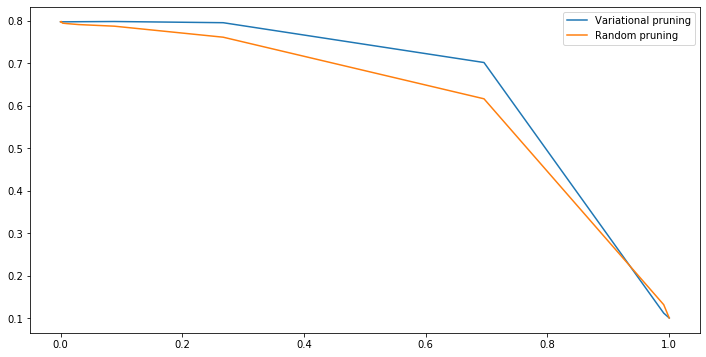

In [15]:
plt.figure(figsize = (12,6))
plt.plot(pruned_list, v_accs, label='Variational pruning')
plt.plot(pruned_list, r_accs, label='Random pruning')
plt.legend()
plt.show()

Как можно заметить, байесовское удаление параметров работает лучше, чем случайное.